In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
import math
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.stats import boxcox
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("data.csv")

In [3]:
def feature_engineering(df):
    df = df.drop(["Operator", "Registration", "Survivors", "MSN", "Date", "Time",
             "Schedule", "Crew fatalities", "PAX fatalities", "Other fatalities",
             "Circumstances", "Flight no.", "Crash location"], axis=1)
    df = df.dropna()
    new_names = {name: "_".join(name.lower().split()) for name in df.columns}
    df = df.rename(columns=new_names)
    label_encoder = LabelEncoder()
    df = df.apply(lambda col: label_encoder.fit_transform(col) if col.dtype == 'O' else col)
    return df
    
df = feature_engineering(df)

Детерминант матрицы парных корреляций: 0.3864715012306377


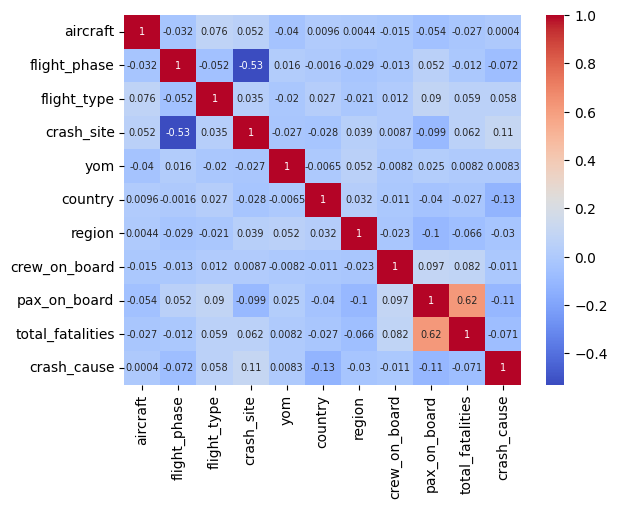

In [4]:
def corr_analysis(df):
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", annot_kws={"size": 7})
    print(f'Детерминант матрицы парных корреляций: {np.linalg.det(df.corr().to_numpy())}')

corr_analysis(df)

In [5]:
y = df["total_fatalities"]
X = df.drop(["total_fatalities", "country", "aircraft", "flight_type", "yom"], axis=1)

Процент вхождений в интервал 1 сигмы: 94.64989592098853
Процент вхождений в интервал 2 сигм: 97.14779219628859
Процент вхождений в интервал 3 сигм: 98.2151556756278
Пусть гипотеза H0 - совокупность распределена нормально
1.1197637492286128e+199
23.684791304840576
На основании проведенного теста с помощью критерия Пирсона: Отвергаем H0


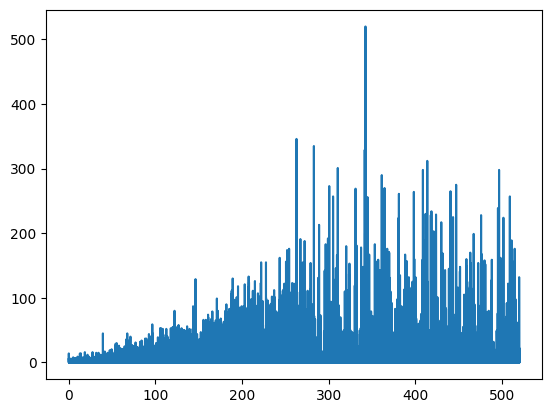

In [6]:
# Проверка на нормальное распределение выходной величины y

# Правило трёх сигм
data = y
mean_data = np.mean(data)
std_data = np.std(data)

def get_interval(k_sigma, mean_value, std_value):
    return [mean_value - k_sigma * std_value, mean_value + k_sigma * std_value]

def get_percent(k, data):
    mean_data = np.mean(data)
    std_data = np.std(data)

    interval = get_interval(k, mean_data, std_data)

    return sum([1 if x >= interval[0] and x <= interval[1] else 0 for x in data]) / len(data) * 100

percent_68 = get_percent(1, data)
percent_95 = get_percent(2, data)
percent_99 = get_percent(3, data)
print(f"Процент вхождений в интервал 1 сигмы: {percent_68}")
print(f"Процент вхождений в интервал 2 сигм: {percent_95}")
print(f"Процент вхождений в интервал 3 сигм: {percent_99}")

# Критерий Пирсона
# Разделим данные на интервалы
def get_interval_distribution(data):
    k = int(np.round(1 + 3.322 * np.log10(len(data))))
    min_age = math.floor(min(data))
    max_age = math.ceil(max(data))
    h = (max_age - min_age) / k
    
    intervals = [(min_age + i * h, min_age + (i + 1) * h) for i in range(k)]
    distr = {intr:0 for intr in intervals}
    for x in data:
        for intr in intervals:
            if x >= intr[0] and x <= intr[1]:
                distr[intr] += 1
                break
    return (distr, k, h)

def chi_square(data):
    distr, k, h = get_interval_distribution(data)
    sum_xn = 0
    sum_x2n = 0
    # Вычисляем среднее, дисперсию и среднекв. отклонение (х - середина интервала)
    for inter, n in distr.items():
        lower, upper = inter[0], inter[1]
        x = (upper + lower) / 2
        sum_xn += x * n
        sum_x2n += (x ** 2) * n
    mean_value = sum_xn / len(data)
    variance = (sum_x2n / len(data)) - (mean_value ** 2)
    std_value = variance ** 0.5
    # Строим массив теоретических частот
    theor_freqs = []
    freqs = []
    for inter, n in distr.items():
        lower, upper = inter[0], inter[1]
        x = (upper + lower) / 2
        z = (x - mean_value) / std_value
        f_z = math.exp((-(z)**2) / 2) / math.sqrt(2 * math.pi)
        theor_n = ((h * len(data)) / std_value) * f_z
        theor_freqs.append(theor_n)
        freqs.append(n)
    # Хи-квадрат наблюдаемое
    chi2_obs = sum([((freqs[i] - theor_freqs[i]) ** 2) / theor_freqs[i] for i in range(len(distr))])
    print(chi2_obs)
    # Хи-квадрат критическое
    chi2_crit = ss.chi2.ppf(1 - 0.05, k - 1)
    print(chi2_crit)
    plt.plot(np.linspace(min(data), max(data), len(data)), data)
    return "Отвергаем H0" if chi2_obs > chi2_crit else "Недостаточно оснований отвергнуть H0"
print("Пусть гипотеза H0 - совокупность распределена нормально")
print("На основании проведенного теста с помощью критерия Пирсона: " + chi_square(data))

((array([-4.00737797, -3.79268046, -3.67526106, ...,  3.67526106,
          3.79268046,  4.00737797]),
  array([  0,   0,   0, ..., 335, 346, 520], dtype=int64)),
 (10.438578617309144, 6.070242260507555, 0.5649395358087723))

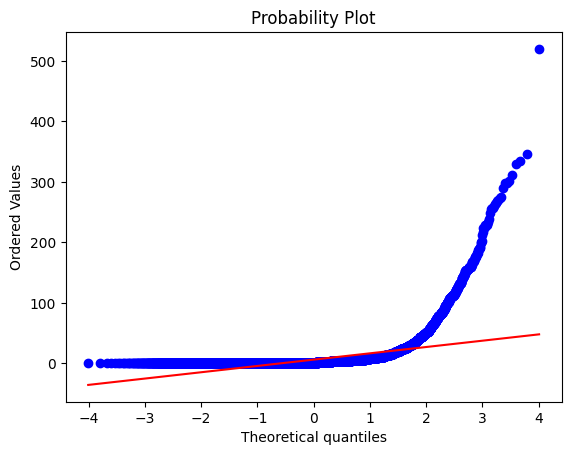

In [7]:
plt.subplot(1, 1, 1)
ss.probplot(data, plot=plt)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
def with_intercept(X):
    new_X = X.copy()
    new_X["intercept"] = 1
    return new_X
    
model = sm.OLS(y_train, with_intercept(X_train)).fit()
y_pred = model.predict(with_intercept(X_test))

In [10]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       total_fatalities   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     1614.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:30:33   Log-Likelihood:                -61870.
No. Observations:               15127   AIC:                         1.238e+05
Df Residuals:                   15120   BIC:                         1.238e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
flight_phase      0.4750      0.119      4.004      0.000       0.242       0.708
crash_site        1.2184      0.064     18.921      0.000       1.092       1.345
region           -0.0755      0.061     -1.230      0.219      -0.196       0.045
crew_on_board     0.0179      0.007      2.412      0.016       0.003       0.033
pax_on_board      0.4257      0.004     95.905      0.000       0.417       0.434
crash_cause      -0.1831      0.067     -2.750      0.006      -0.314      -0.053
intercept        -0.3018      0.386     -0.782      0.434      -1.058       0.454
==============================================================================
Omnibus:                    10872.751   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2298527.607
Skew:                           2.464   Prob(JB):                         0.00
Kurtosis:                      63.187   Cond. No.                         96.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
def print_scores(y_test, y_pred, k):
    n = len(y_test)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"R2_score: {r2}")
    print(f"Adjusted R2_score: {adj_r2}")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
print_scores(y_test, y_pred, len(X.columns))

R2_score: 0.4176160864349302
Adjusted R2_score: 0.41714673741123776
MSE: 196.9563140672049
MAE: 5.904575103620178
